Building likelihood maps for a set of representative images.

> TODO: use images from dataset and superimpose the bounding boxes on them


In [ ]:
import retinoto_py as fovea
args = fovea.Params(do_fovea=True, batch_size=1, subset_factor=50)
args

Params(image_size=224, do_mask=False, do_fovea=True, rs_min=0.0, rs_max=-7.5, padding_mode='zeros', seed=2025, batch_size=1, num_workers=1, in_memory=False, model_name='convnext_base', num_epochs=41, subset_factor=25, lr=2e-07, delta1=0.2, delta2=0.007, weight_decay=0.003, label_smoothing=0.05, shuffle=True, verbose=False)

In [2]:
dataset = 'bbox'

VAL_DATA_DIR = args.DATAROOT / f'Imagenet_{dataset}' / 'val'
val_dataset = fovea.get_dataset(args, VAL_DATA_DIR)
val_loader = fovea.get_loader(args, val_dataset)


In [3]:
model_filename = args.data_cache /  f'32_fovea_model_name={args.model_name}_dataset={dataset}.pth'
model = fovea.load_model(args, model_filename=model_filename)

In [4]:
from torchvision.transforms import v2 as transforms
npy_filename = args.data_cache / '42_likelihood_maps.npy'

%rm {npy_filename}


rm: cached_data/42_likelihood_maps.npy: No such file or directory


In [ ]:

resolution = (100, 100)
resolution = (30, 30)
resolution = (20, 20)
size_ratio = .4

if npy_filename.exists():
    results = fovea.np.load(npy_filename)
else:
    n_dataset = len(val_dataset)
    with fovea.torch.no_grad():
        results = fovea.np.empty((resolution[0], resolution[1], n_dataset))
        # for i_batch, (image, true_label) in fovea.tqdm(enumerate(val_dataset), total=n_dataset):
        for i_batch, (image, true_label) in fovea.tqdm(enumerate(val_loader), total=n_dataset):
            image, true_label = image.to(args.device), true_label.to(args.device)

            pos_H, pos_W, probas = fovea.compute_likelihood_map(args, model, image.squeeze(0), size_ratio=size_ratio, resolution=resolution)
            results[:, :, i_batch] = probas[:, true_label].cpu().numpy().reshape(resolution)
        fovea.np.save(npy_filename, results)        

  0%|          | 0/2000 [00:00<?, ?it/s]

In [6]:
# fig, ax = fovea.plt.subplots()
# contour = ax.contourf(results.mean(axis=-1))
# fig.colorbar(contour, ax=ax)  # Add colorbar
# ax.axis('square')
# fig.set_facecolor(color='white')


In [7]:
results.min(), results.max()

(np.float64(2.0198092897771858e-05), np.float64(0.9593453407287598))

In [8]:
results.max(axis=-1).shape

(20, 20)

In [9]:
results.shape

(20, 20, 2000)

In [10]:
i_image = 42
proba = results[:, :, :, i_image]
proba.min(), proba.max()

IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

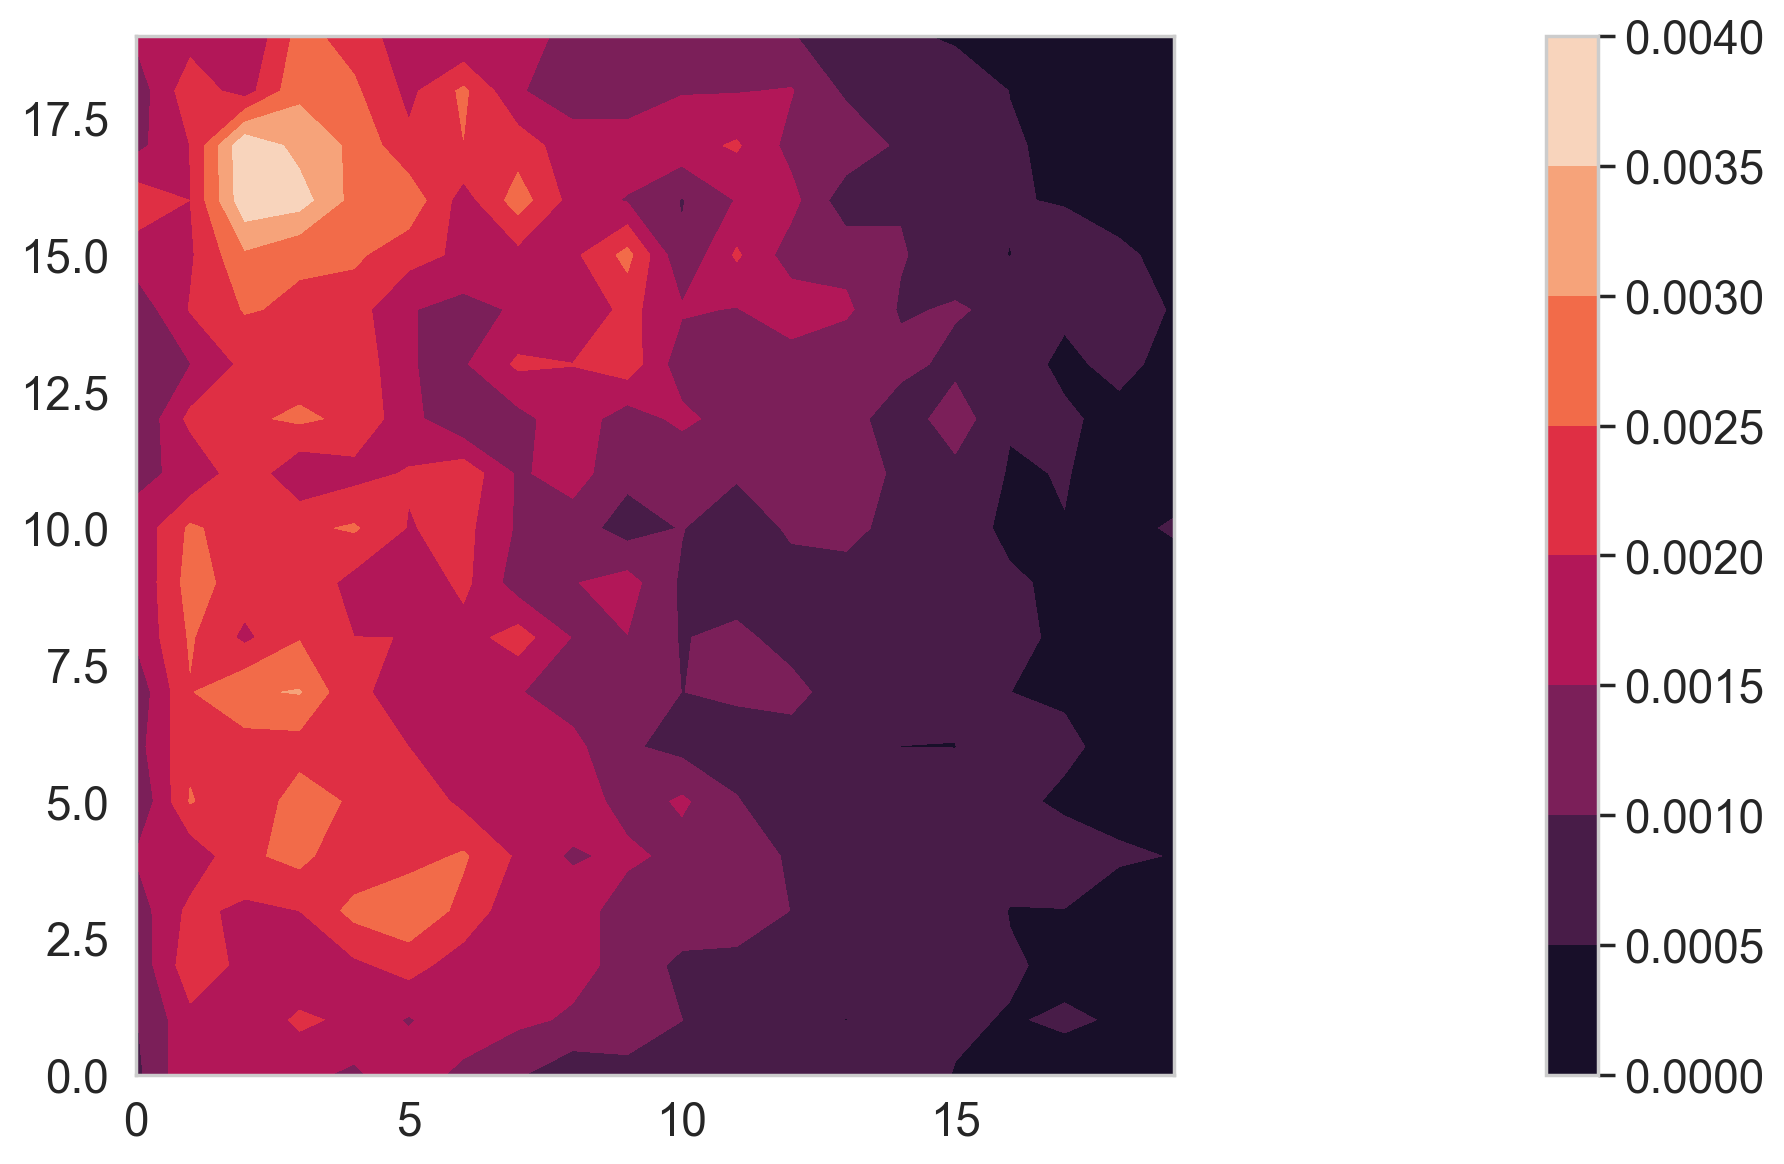

In [11]:
fig, ax = fovea.plt.subplots()
contour = ax.contourf(results.mean(axis=-1))
fig.colorbar(contour, ax=ax)  # Add colorbar
ax.axis('square')
fig.set_facecolor(color='white')


In [ ]:
results.max(axis=(0, 1, 2)).shape

In [ ]:
accuracy = results.max(axis=(0, 1, 2))
fig, ax = fovea.plt.subplots()
ax.hist(accuracy)


In [ ]:
dataset = fovea.get_dataset(args, VAL_DATA_DIR)
len(dataset)


In [ ]:
from torchvision import datasets

dataset = datasets.ImageFolder(root=VAL_DATA_DIR)
len(dataset), len(dataset.targets), dataset.targets[51:53]

In [ ]:

# Get all targets

import numpy as np 
targets = np.array(dataset.targets)
targets[:53]

In [ ]:

# Get unique classes and their indices
classes, counts = np.unique(targets, return_counts=True)
classes, counts


In [ ]:
len(classes)

In [ ]:
subset_factor = 50
# Calculate the number of samples per class in the subset
n_per_class = min(counts) // subset_factor
n_per_class

In [ ]:
cls = 0
cls_indices = np.where(targets == cls)[0]
cls_indices

In [ ]:

# Sample indices for each class
subset_indices = []
for cls in classes:
    cls_indices = np.where(targets == cls)[0]
    np.random.shuffle(cls_indices)
    subset_indices.extend(cls_indices[:n_per_class])


# Shuffle the subset indices
# np.random.shuffle(subset_indices)

len(subset_indices)

In [ ]:
from torch.utils.data import Dataset, DataLoader, Subset
sub_dataset = Subset(dataset, subset_indices)


In [ ]:
len(sub_dataset)

In [ ]:
sub_dataset